In [1]:
import numpy as np 
import pandas as pd
import os

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, TimeDistributed, Flatten
from keras.preprocessing.sequence import pad_sequences

print(os.listdir("../input"))

Using TensorFlow backend.


['ner_dataset.csv', 'ner.csv']


In [2]:
dframe = pd.read_csv("../input/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
dframe.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [3]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word','shape'],axis=1)

In [4]:
dataset.head(10)

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O
5,IN,1.0,through,O
6,NNP,1.0,London,B-geo
7,TO,1.0,to,O
8,VB,1.0,protest,O
9,DT,1.0,the,O


In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
sentences[1]

[('Families', 'O'),
 ('of', 'O'),
 ('soldiers', 'O'),
 ('killed', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('conflict', 'O'),
 ('joined', 'O'),
 ('the', 'O'),
 ('protesters', 'O'),
 ('who', 'O'),
 ('carried', 'O'),
 ('banners', 'O'),
 ('with', 'O'),
 ('such', 'O'),
 ('slogans', 'O'),
 ('as', 'O'),
 ('"', 'O'),
 ('Bush', 'B-per'),
 ('Number', 'O'),
 ('One', 'O'),
 ('Terrorist', 'O'),
 ('"', 'O'),
 ('and', 'O'),
 ('"', 'O'),
 ('Stop', 'O'),
 ('the', 'O'),
 ('Bombings', 'O'),
 ('.', 'O'),
 ('"', 'O'),
 ('Families', 'O'),
 ('of', 'O'),
 ('soldiers', 'O'),
 ('killed', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('conflict', 'O'),
 ('joined', 'O'),
 ('the', 'O'),
 ('protesters', 'O'),
 ('who', 'O'),
 ('carried', 'O'),
 ('banners', 'O'),
 ('with', 'O'),
 ('such', 'O'),
 ('slogans', 'O'),
 ('as', 'O'),
 ('"', 'O'),
 ('Bush', 'B-per'),
 ('Number', 'O'),
 ('One', 'O'),
 ('Terrorist', 'O'),
 ('"', 'O'),
 ('and', 'O'),
 ('"', 'O'),
 ('Stop', 'O'),
 ('the', 'O'),
 ('Bombings', 'O'),
 ('.', 'O'),
 ('"', 'O')]

In [7]:
sentences = [[s[0].lower() for s in sent] for sent in getter.sentences]
sentences[1]

['families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banners',
 'with',
 'such',
 'slogans',
 'as',
 '"',
 'bush',
 'number',
 'one',
 'terrorist',
 '"',
 'and',
 '"',
 'stop',
 'the',
 'bombings',
 '.',
 '"',
 'families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banners',
 'with',
 'such',
 'slogans',
 'as',
 '"',
 'bush',
 'number',
 'one',
 'terrorist',
 '"',
 'and',
 '"',
 'stop',
 'the',
 'bombings',
 '.',
 '"']

In [8]:
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [9]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [10]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

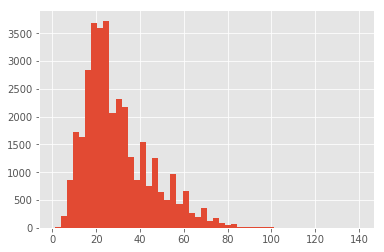

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
words = np.array([x.lower() if isinstance(x, str) else x for x in dataset["word"].values])
words = list(set(words))
words.append('unk')
words.append('pad')
n_words = len(words); n_words

27422

In [13]:
tags = list(set(dataset["tag"].values))
n_tags = len(tags)
n_tags

18

In [14]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
tag2idx

{nan: 0,
 'B-art': 1,
 'I-org': 2,
 'I-per': 3,
 'I-eve': 4,
 'B-tim': 5,
 'B-org': 6,
 'I-gpe': 7,
 'I-tim': 8,
 'B-eve': 9,
 'B-geo': 10,
 'I-art': 11,
 'B-per': 12,
 'B-gpe': 13,
 'I-geo': 14,
 'O': 15,
 'I-nat': 16,
 'B-nat': 17}

In [16]:
word2idx['unk']

27420

In [17]:
X = [[word2idx.get(w,'27420') for w in s] for s in sentences]
X[1]

[7503,
 4230,
 976,
 5984,
 20658,
 15602,
 5150,
 10258,
 15602,
 8523,
 10565,
 25314,
 25191,
 11845,
 9996,
 6536,
 3980,
 11779,
 26933,
 22415,
 10882,
 10224,
 11779,
 1029,
 11779,
 7857,
 15602,
 2077,
 20485,
 11779,
 7503,
 4230,
 976,
 5984,
 20658,
 15602,
 5150,
 10258,
 15602,
 8523,
 10565,
 25314,
 25191,
 11845,
 9996,
 6536,
 3980,
 11779,
 26933,
 22415,
 10882,
 10224,
 11779,
 1029,
 11779,
 7857,
 15602,
 2077,
 20485,
 11779]

In [18]:
y = [[tag2idx.get(l) for l in lab] for lab in labels]
y[1]

[15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 12,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 12,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15]

In [19]:
X = pad_sequences(maxlen=140, sequences=X, padding="post", value=n_words-1)

In [20]:
word2idx['pad'], n_words-1

(27421, 27421)

In [21]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [22]:
y[1]

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 12, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15], dtype=int32)

In [23]:
X[1]

array([ 7503,  4230,   976,  5984, 20658, 15602,  5150, 10258, 15602,
        8523, 10565, 25314, 25191, 11845,  9996,  6536,  3980, 11779,
       26933, 22415, 10882, 10224, 11779,  1029, 11779,  7857, 15602,
        2077, 20485, 11779,  7503,  4230,   976,  5984, 20658, 15602,
        5150, 10258, 15602,  8523, 10565, 25314, 25191, 11845,  9996,
        6536,  3980, 11779, 26933, 22415, 10882, 10224, 11779,  1029,
       11779,  7857, 15602,  2077, 20485, 11779, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421,

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [25]:
y_train = keras.utils.to_categorical(y_train)
print(X_train.shape, y_train.shape)

(28141, 140) (28141, 140, 18)


In [26]:
model = Sequential()

model.add(Embedding(n_words, 50))
model.add(Bidirectional(LSTM(140, return_sequences=True)))
model.add(Bidirectional(LSTM(140, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=150, epochs=5, verbose=1, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 22512 samples, validate on 5629 samples
Epoch 1/5
22512/22512 [==============================] - 114s 5ms/step - loss: 0.2810 - acc: 0.9609 - val_loss: 0.1494 - val_acc: 0.9674
Epoch 2/5
22512/22512 [==============================] - 108s 5ms/step - loss: 0.1136 - acc: 0.9704 - val_loss: 0.0805 - val_acc: 0.9762
Epoch 3/5
22512/22512 [==============================] - 107s 5ms/step - loss: 0.0679 - acc: 0.9790 - val_loss: 0.0643 - val_acc: 0.9812
Epoch 4/5
22512/22512 [==============================] - 107s 5ms/step - loss: 0.0534 - acc: 0.9845 - val_loss: 0.0553 - val_acc: 0.9851
Epoch 5/5
22512/22512 [==============================] - 106s 5ms/step - loss: 0.0419 - acc: 0.9888 - val_loss: 0.0462 - val_acc: 0.9877


In [27]:
pred = model.predict(X_test)   

In [28]:
 pred

array([[[4.6552694e-05, 7.9712179e-04, 1.5183000e-04, ...,
         1.6866018e-04, 1.0348230e-04, 1.2616835e-04],
        [3.2441440e-06, 3.4225752e-05, 2.5458969e-04, ...,
         9.9751544e-01, 1.8300203e-05, 4.2048636e-05],
        [7.6127174e-07, 2.9680346e-05, 1.0246923e-04, ...,
         9.9861383e-01, 3.6924455e-06, 3.7627400e-05],
        ...,
        [2.2434350e-09, 2.2967736e-08, 1.0087494e-08, ...,
         9.9999893e-01, 2.1012629e-09, 2.6517766e-08],
        [5.5949125e-09, 5.6834885e-08, 2.3750808e-08, ...,
         9.9999762e-01, 5.2062261e-09, 6.3506775e-08],
        [1.9111563e-07, 2.1815590e-06, 9.0732220e-07, ...,
         9.9994874e-01, 1.5598224e-07, 1.8049953e-06]],

       [[3.9322335e-06, 6.3425527e-05, 2.7549872e-04, ...,
         9.9772853e-01, 1.9363144e-05, 7.0020440e-05],
        [5.6698241e-07, 1.9156483e-05, 6.7832778e-05, ...,
         9.9914098e-01, 2.3533378e-06, 2.3468552e-05],
        [2.2676536e-06, 1.4995440e-04, 3.1101663e-04, ...,
         9.910

**Functional API**

In [29]:
# input = Input(shape=(140,))
# model = Embedding(n_words, 50)(input)
# model = Bidirectional(LSTM(units=140, return_sequences=True))(model)
# model = Bidirectional(LSTM(units=140, return_sequences=True))(model)
# # reshape = keras.layers.Reshape((-1, 140, 1))(model)

# out = TimeDistributed(Dense(18, activation="softmax"))(model)  # softmax output layer
# model = Model(input, out)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model.fit(X_train, y_train, batch_size=150, epochs=1, verbose=1)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1371100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 280)         213920    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 280)         471520    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 18)          5058      
Total params: 2,061,598
Trainable params: 2,061,598
Non-trainable params: 0
_________________________________________________________________


In [31]:
i = 5
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
the           : O
u.s.          : B-geo
official      : O
stressed      : O
the           : O
only          : O
way           : O
to            : O
successfully  : O
counter       : O
the           : O
threat        : O
is            : O
to            : O
learn         : O
to            : O
work          : O
effectively   : O
together      : O
.             : O
the           : O
u.s.          : B-geo
official      : O
stressed      : O
the           : O
only          : O
way           : O
to            : O
successfully  : O
counter       : O
the           : O
threat        : O
is            : O
to            : O
learn         : O
to            : O
work          : O
effectively   : O
together      : O
.             : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad      